# Live-updating multi-tau one-time correlation with synthetic and real data

In [1]:
from skbeam.core.correlation import lazy_one_time
import numpy as np
import time as ttime
import matplotlib.pyplot as plt
%matplotlib notebook

## First, let's demo with synthetic data.

The plot a few cells down should live update with the first value of approximately sqrt(2) and the remaining values should be essentially one

In [2]:
num_levels = 5
num_bufs = 4  # must be even
xdim = 512
ydim = 512
stack_size = 100
synthetic_data = np.random.randint(1, 10, (stack_size, xdim, ydim))

rois = np.zeros_like(synthetic_data[0])
# make sure that the ROIs can be any integers greater than 1. They do not
# have to start at 1 and be continuous
rois[0:xdim//10, 0:ydim//10] = 5
rois[xdim//10:xdim//5, ydim//10:ydim//5] = 3

### Define a helper function to process and update the live plot

In [3]:
def update_plot(ax, g2s, lags, img_num):
    ax.cla()
    for n, g2 in enumerate(g2s.T):
        ax.plot(lags[:len(g2)], g2, '-o', label='roi%s' % n)
    ax.set_title('processed %s images' % img_num)
    ax.legend(loc=0)
    ax.set_xlabel('Log time (s)')
    ax.set_ylabel('Correlation')
    try:
        ax.set_xscale('log')
        ax.figure.canvas.draw()
    except ValueError:
        # this happens on the first few draws
        ax.set_xscale('linear')
        ax.figure.canvas.draw()
    ttime.sleep(0.001)

## Show the correlator working with synthetic data

<IPython.core.display.Javascript object>


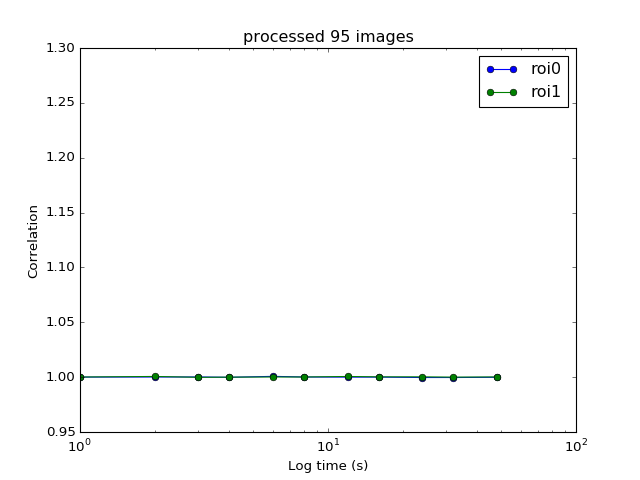

In [4]:
fig, ax = plt.subplots()


In [5]:
corr_gen = lazy_one_time(synthetic_data, num_levels, num_bufs, rois)
for counter, res in enumerate(corr_gen):
    # only update the plot every 5th image processed.
    if counter % 5 == 0:
        update_plot(ax, res.g2, res.lag_steps, counter)

/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:199: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.float64)
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index] += ((binned / num_pixels -
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index]) / normalize)


## Now let's do it with some real data

In [40]:
from skbeam.core import roi
from xray_vision.mpl_plotting import show_label_array

In [7]:
pwd

'/Volumes/Data/ipython_NoteBooks/my_ipy_notebook/NYSDS'

In [8]:
# multi-tau scheme info
real_data_levels = 7
real_data_bufs = 8
real_data = np.load("/Volumes/Data/All_NSLS2/scikit-beam-examples/demos/time_correlation/100_500_NIPA_GEL.npy")

# generate some circular ROIs
# define the ROIs
roi_start = 65 # in pixels
roi_width = 9 # in pixels
roi_spacing = (5.0, 4.0)
x_center = 7. # in pixels
y_center = (129.) # in pixels
num_rings = 3

# get the edges of the rings
edges = roi.ring_edges(roi_start, width=roi_width, 
                       spacing=roi_spacing, num_rings=num_rings)

# get the label array from the ring shaped 3 region of interests(ROI's)
labeled_roi_array = roi.rings(
    edges, (y_center, x_center), real_data.shape[1:])

### Plot the ROIs over the averaged image

<IPython.core.display.Javascript object>


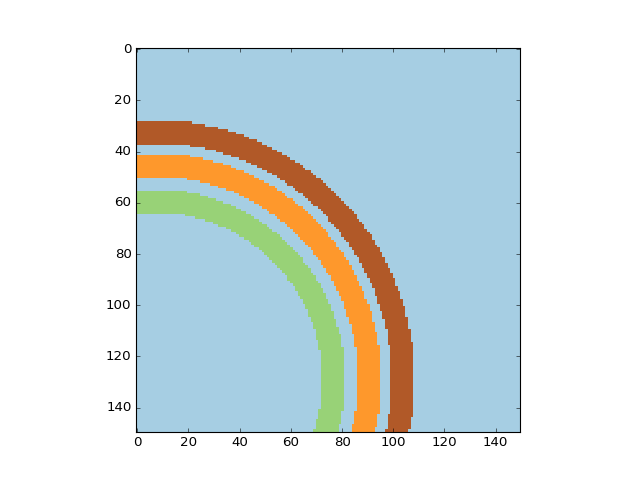

In [41]:
fig, ax = plt.subplots()
ax.imshow(np.sum(real_data, axis=0) / len(real_data))
show_label_array(ax, labeled_roi_array)

### Use the class-based partial data correlator in scikit-beam

<IPython.core.display.Javascript object>


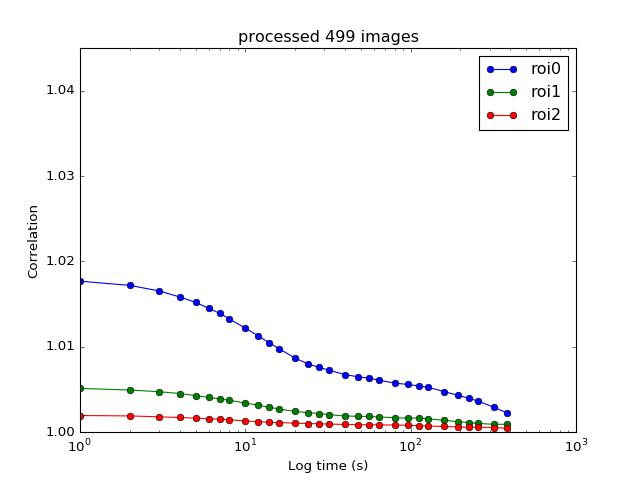

In [10]:
fig2, ax2 = plt.subplots()
ax2.set_xscale('log')

#### Show incremental updates with the generator implementation of the correlator

In [11]:
gen = lazy_one_time(real_data, real_data_levels, real_data_bufs, labeled_roi_array)
for counter, result in enumerate(gen):
    # update image every 10th image for performance
    if counter % 10 == 0:
        update_plot(ax2, result.g2, result.lag_steps, counter)
else:
    # do a final update to get the last bit
    update_plot(ax2, result.g2, result.lag_steps, counter)

/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:199: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.float64)
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index] += ((binned / num_pixels -
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index]) / normalize)


In [12]:
gen = lazy_one_time(real_data, real_data_levels, real_data_bufs, labeled_roi_array)
gen

<generator object lazy_one_time at 0x11c737f30>

In [13]:
import copy
result_g2 = []
lag = []
for result in gen:
    r_g2 = copy.copy(result.g2)
    lags = copy.copy(result.lag_steps)
    result_g2.append(r_g2)
    lag.append(lags)

/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:199: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.float64)
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index] += ((binned / num_pixels -
/Volumes/Data/All_NSLS2/scikit-beam/skbeam/core/correlation.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr[t_index]) / normalize)


In [14]:
len(result_g2)

500

In [15]:
result.lag_steps

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  12,  14,  16,
        20,  24,  28,  32,  40,  48,  56,  64,  80,  96, 112, 128, 160,
       192, 224, 256, 320, 384])

In [16]:
lag[0], lag[1], lag[5]

(array([0]), array([0, 1]), array([0, 1, 2, 3, 4, 5]))

In [17]:
result_g2[0].shape, result_g2[1].shape, result_g2[5].shape

((1, 3), (2, 3), (6, 3))

<IPython.core.display.Javascript object>


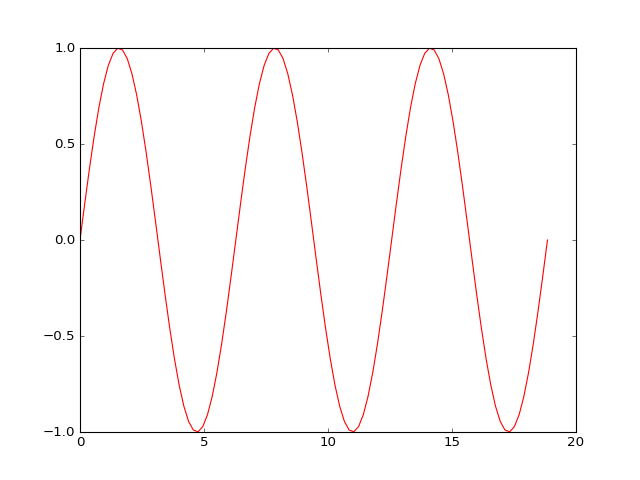

In [21]:
x = np.linspace(0, 6*np.pi, 100)
y = np.sin(x)

# You probably won't need this if you're embedding things in a tkinter plot...
plt.ion()

fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'r-') # Returns a tuple of line objects, thus the comma

for phase in np.linspace(0, 10*np.pi, 500):
    line1.set_ydata(np.sin(x + phase))
    fig.canvas.draw()

<IPython.core.display.Javascript object>


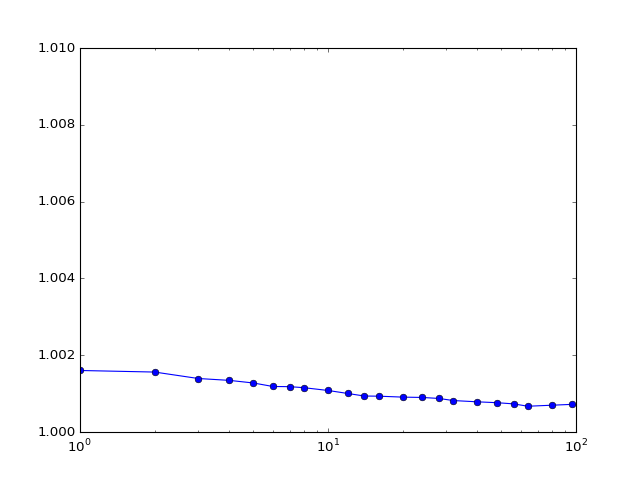

In [19]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(lag[20], result_g2[20][:,2], "-o") 
ax.set_xscale('log')


def animate(i):
    line1.set_xdata(lag[i])
    line1.set_ydata(result_g2[i][:, 2])
    #line1.set_xdata(lag[i])
    return line1,


# Init only required for blitting to give a clean slate.
#def init():
#    line.set_ydata(np.ma.array(x, mask=True))
#    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(20, 500), 
                              interval=25, blit=True)
plt.show()

#  following is the movie code

In [38]:
def one_time_movie(data, lags, movie_name, interval=25,
                   fps=15, movie_writer='avconv'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    line1, = ax.plot(lag[20], result_g2[20][:,2], "-o") 
    ax.set_xscale('log')
    #ax.set_ylabel("g$^{(2)}$")
    #ax.set_xlabel("time(s)")
    fig.set_size_inches([5, 5])

    def animate(i):
        line1.set_xdata(lag[i])
        line1.set_ydata(result_g2[i][:, 2])
        return line1,


    ani = animation.FuncAnimation(fig, animate, np.arange(20, 500), 
                                  interval=25)
    writer = animation.writers[movie_writer](fps=fps)
    ani.save(movie_name, writer=writer)
    return ani
    

<IPython.core.display.Javascript object>


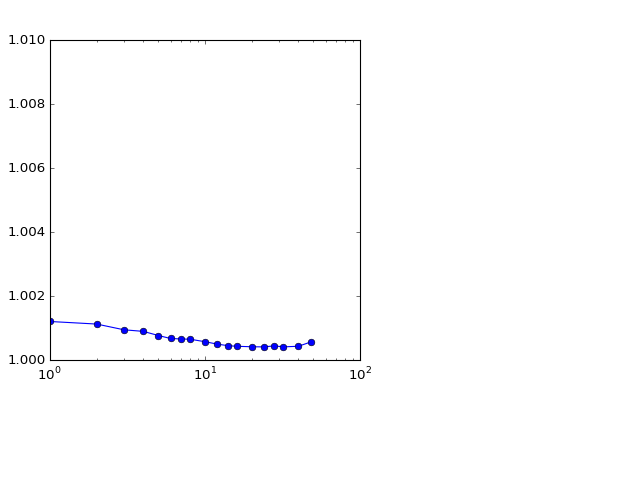

In [39]:
one_time_movie(result_g2, lag, movie_name="one_time.mp4", interval=25, fps=15)

